<a href="https://colab.research.google.com/github/rsoekarta79/OBJECTIVE1/blob/main/OBJECTIVE_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMAGE PROCESSING**

# **GAUSSIAN**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/250


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.2250 - loss: 3.7137 - val_accuracy: 0.1881 - val_loss: 2.4833 - learning_rate: 1.0000e-05
Epoch 2/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 740ms/step - accuracy: 0.2315 - loss: 3.4263 - val_accuracy: 0.2086 - val_loss: 2.3758 - learning_rate: 1.0000e-05
Epoch 3/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 752ms/step - accuracy: 0.2652 - loss: 3.1877 - val_accuracy: 0.2638 - val_loss: 2.2858 - learning_rate: 1.0000e-05
Epoch 4/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 743ms/step - accuracy: 0.2506 - loss: 3.2010 - val_accuracy: 0.3149 - val_loss: 2.2085 - learning_rate: 1.0000e-05
Epoch 5/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 743ms/step - accuracy: 0.2787 - loss: 2.9920 - val_accuracy: 0.3538 - val_loss: 2.1258 - learning_rate: 1.0000e-05
Epoch 6/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 758ms/step - accuracy: 0.2953 - loss: 2.9023 - val_accuracy: 0.4254 - val_loss: 2.0558 - learning_rate: 1.0000e-05
Epoch 7/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 744ms/step - accuracy: 

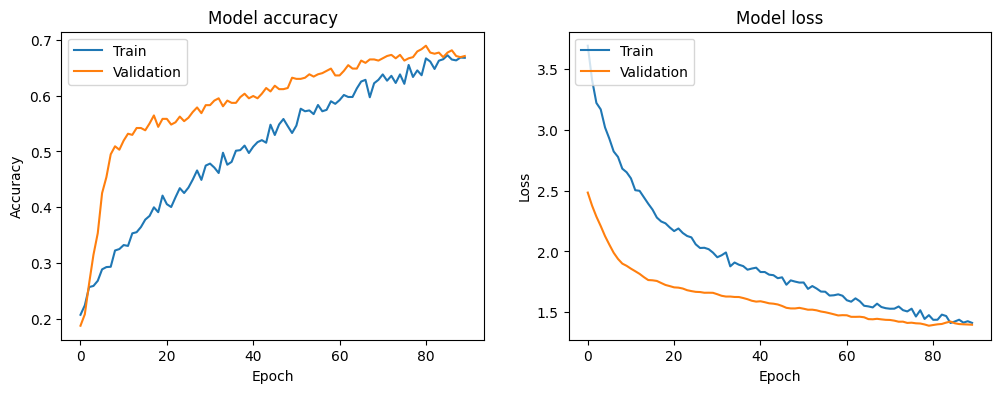

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step
              precision    recall  f1-score   support

     Aitinyo       0.52      0.67      0.58        92
     Ayamaru       0.65      0.59      0.62       106
      Kokoda       0.83      0.81      0.82        85
         Moi       0.97      0.67      0.79        94
       Tehit       0.62      0.69      0.65       112

    accuracy                           0.68       489
   macro avg       0.72      0.69      0.69       489
weighted avg       0.71      0.68      0.69       489



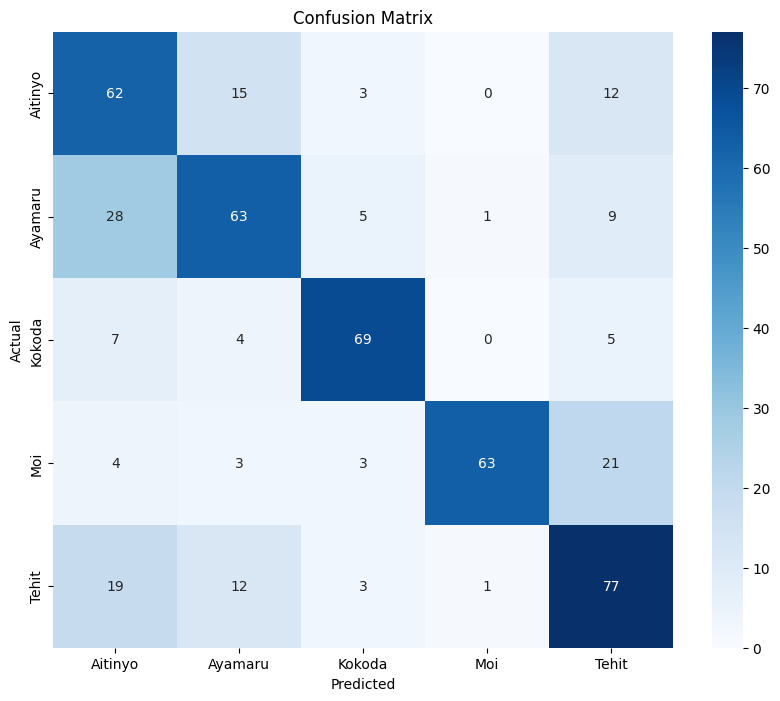

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 250

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust the path to your dataset path

# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Apply Gaussian blur
    image = cv2.GaussianBlur(image, (5, 5), 0)
    # Convert to RGB if necessary
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    return image

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    data.append(image)
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

# Encode labels for training
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_datagen.flow(train_data, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_data, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **HAAR WAVELET**

Epoch 1/250


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.2097 - loss: 3.4457 - val_accuracy: 0.1881 - val_loss: 2.6259 - learning_rate: 1.0000e-05
Epoch 2/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 758ms/step - accuracy: 0.2004 - loss: 3.3485 - val_accuracy: 0.2127 - val_loss: 2.5345 - learning_rate: 1.0000e-05
Epoch 3/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 741ms/step - accuracy: 0.2111 - loss: 3.3770 - val_accuracy: 0.2290 - val_loss: 2.4530 - learning_rate: 1.0000e-05
Epoch 4/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 744ms/step - accuracy: 0.2428 - loss: 3.1384 - val_accuracy: 0.2556 - val_loss: 2.3960 - learning_rate: 1.0000e-05
Epoch 5/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 742ms/step - accuracy: 0.2196 - loss: 3.1590 - val_accuracy: 0.2720 - val_loss: 2.3668 - learning_rate: 1.0000e-05
Epoch 6/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 729ms/step - accuracy: 0.2492 - loss: 3.0133 - val_accuracy: 0.2638 - val_loss: 2.3399 - learning_rate: 1.0000e-05
Epoch 7/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 752ms/step - accuracy: 

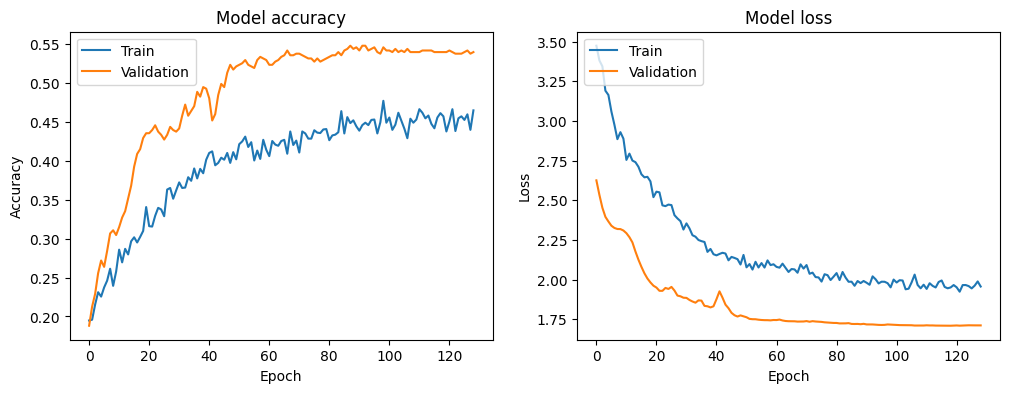

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step
              precision    recall  f1-score   support

     Aitinyo       0.44      0.47      0.45        92
     Ayamaru       0.53      0.39      0.45       106
      Kokoda       0.47      0.66      0.55        85
         Moi       0.70      0.68      0.69        94
       Tehit       0.59      0.54      0.56       112

    accuracy                           0.54       489
   macro avg       0.54      0.55      0.54       489
weighted avg       0.55      0.54      0.54       489



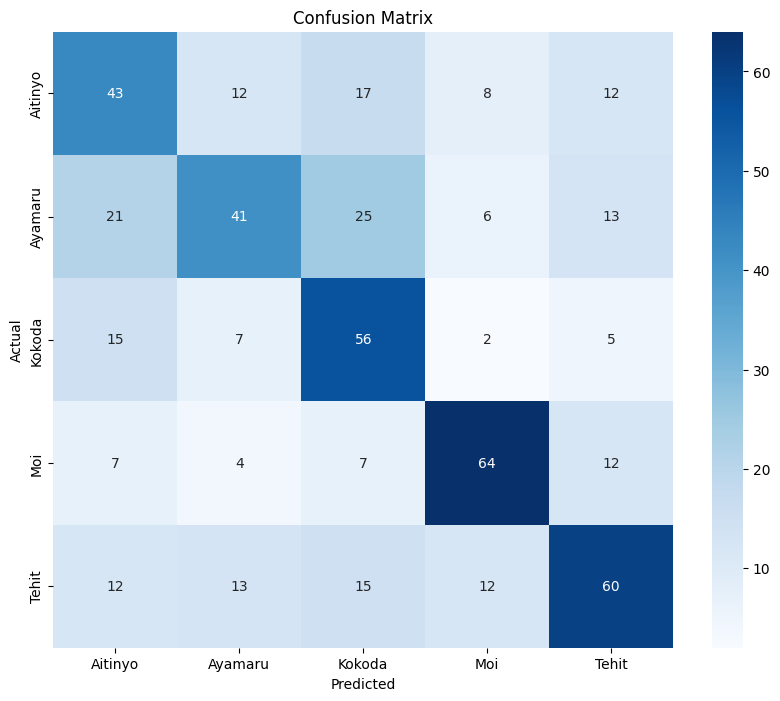

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import pywt  # For Haar wavelet

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 250

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust the path to your dataset path

# Preprocessing Function
def preprocess_image(image):
    # Resize image to 224x224 as expected by the model
    image = cv2.resize(image, IMAGE_SIZE)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Haar wavelet transformation
    coeffs = pywt.dwt2(gray_image, 'haar')  # Haar wavelet decomposition
    LL, (LH, HL, HH) = coeffs  # Get the approximation and detail coefficients

    # Use the LL (approximation) component for further processing
    image = LL

    # Resize the result back to 224x224
    image = cv2.resize(image, IMAGE_SIZE)

    # Convert the processed image to 3 channels (RGB)
    image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    return image

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    data.append(image)
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

# Encode labels for training
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_datagen.flow(train_data, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_data, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **GABOR**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/250


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.1883 - loss: 3.5365 - val_accuracy: 0.2229 - val_loss: 2.5173 - learning_rate: 1.0000e-05
Epoch 2/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 694ms/step - accuracy: 0.2135 - loss: 3.3269 - val_accuracy: 0.2249 - val_loss: 2.6172 - learning_rate: 1.0000e-05
Epoch 3/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 704ms/step - accuracy: 0.1985 - loss: 3.1386 - val_accuracy: 0.1861 - val_loss: 2.5936 - learning_rate: 1.0000e-05
Epoch 4/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 716ms/step - accuracy: 0.1838 - loss: 3.1577 - val_accuracy: 0.1984 - val_loss: 2.6490 - learning_rate: 1.0000e-05
Epoch 5/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 704ms/step - accuracy: 0.1972 - loss: 3.1083 - val_accuracy: 0.2168 - val_loss: 2.6580 - learning_rate: 1.0000e-05
Epoch 6/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 707ms/step - accuracy: 0.2013 - loss: 3.0382 - val_accuracy: 0.2065 - val_loss: 2.5987 - learning_rate: 1.0000e-05
Epoch 7/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 713ms/step - accuracy: 

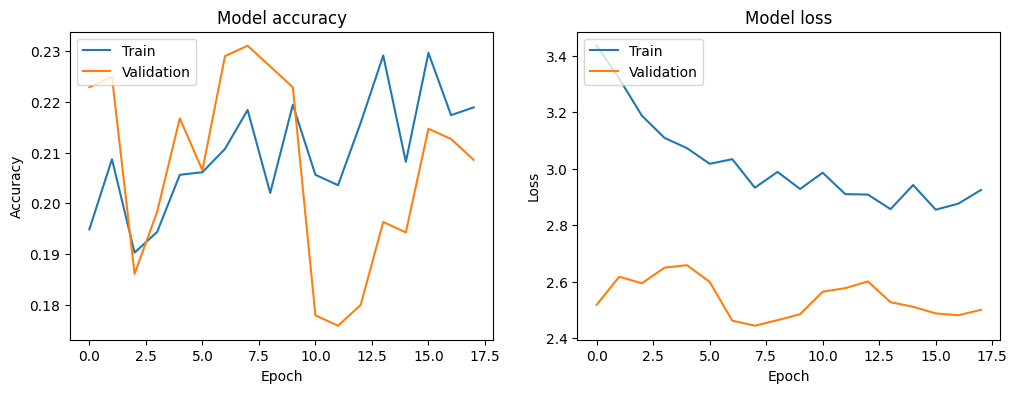

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step
              precision    recall  f1-score   support

     Aitinyo       0.20      0.41      0.27        92
     Ayamaru       0.27      0.08      0.12       106
      Kokoda       0.24      0.64      0.35        85
         Moi       0.00      0.00      0.00        94
       Tehit       0.29      0.12      0.17       112

    accuracy                           0.23       489
   macro avg       0.20      0.25      0.18       489
weighted avg       0.20      0.23      0.17       489



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


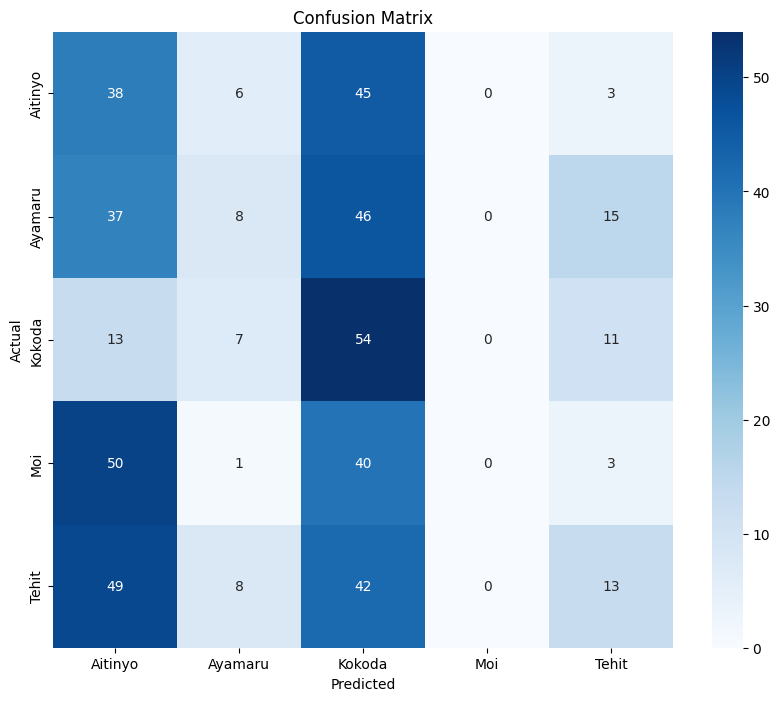

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 250

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust the path to your dataset path

# Gabor Filter Function
def apply_gabor(image):
    """Apply Gabor filter to the image and return the filtered image."""
    gabor_kernels = []
    # Create multiple Gabor filters with different orientations and frequencies
    for theta in [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]:  # 0°, 45°, 90°, 135°
        for sigma in [1, 3]:
            kernel = cv2.getGaborKernel(ksize=(31, 31), sigma=sigma, theta=theta, lambd=10, gamma=0.5, psi=0)
            gabor_kernels.append(kernel)

    # Apply each filter to the grayscale image and combine the results
    filtered_images = []
    for kernel in gabor_kernels:
        filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
        filtered_images.append(filtered_image)

    # Stack and average filtered images to create a combined representation
    combined_image = np.mean(filtered_images, axis=0)
    return combined_image

# Preprocessing Function
def preprocess_image(image):
    # Resize image to 224x224 as expected by the model
    image = cv2.resize(image, IMAGE_SIZE)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gabor filter
    gabor_image = apply_gabor(gray_image)

    # Resize the result back to 224x224
    gabor_image = cv2.resize(gabor_image, IMAGE_SIZE)

    # Convert the processed image to 3 channels (RGB)
    image = cv2.cvtColor(gabor_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    return image

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    data.append(image)
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

# Encode labels for training
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_datagen.flow(train_data, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_data, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **GAUSSIAN + HAAR**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.8 MB/s eta 0:00:00
Epoch 1/250


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.1994 - loss: 3.2719 - val_accuracy: 0.2127 - val_loss: 2.3269 - learning_rate: 1.0000e-05
Epoch 2/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 732ms/step - accuracy: 0.2178 - loss: 3.1715 - val_accuracy: 0.2699 - val_loss: 2.2732 - learning_rate: 1.0000e-05
Epoch 3/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 717ms/step - accuracy: 0.2199 - loss: 3.0654 - val_accuracy: 0.3027 - val_loss: 2.2184 - learning_rate: 1.0000e-05
Epoch 4/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 731ms/step - accuracy: 0.2672 - loss: 2.9474 - val_accuracy: 0.3108 - val_loss: 2.1874 - learning_rate: 1.0000e-05
Epoch 5/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 724ms/step - accuracy: 0.2533 - loss: 2.9360 - val_accuracy: 0.3231 - val_loss: 2.1574 - learning_rate: 1.0000e-05
Epoch 6/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 722ms/step - accuracy: 0.2652 - loss: 2.8656 - val_accuracy: 0.3272 - val_loss: 2.1434 - learning_rate: 1.0000e-05
Epoch 7/250
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 722ms/step - accuracy: 

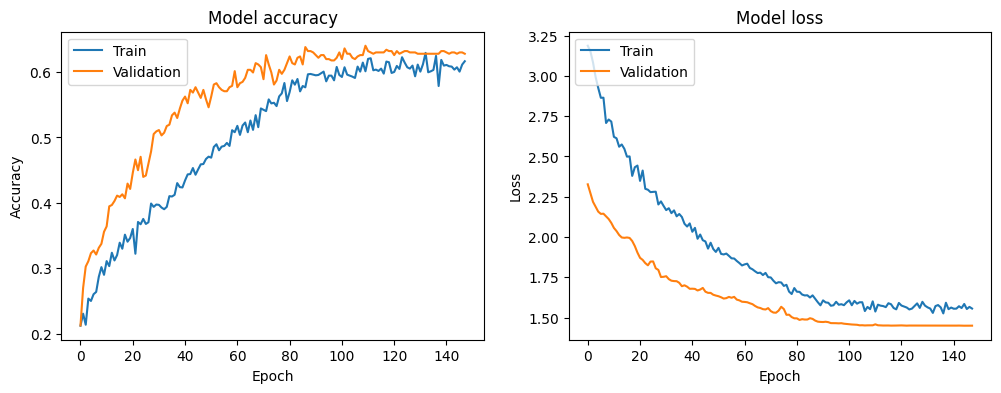

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
              precision    recall  f1-score   support

     Aitinyo       0.44      0.62      0.51        92
     Ayamaru       0.58      0.42      0.49       106
      Kokoda       0.70      0.85      0.77        85
         Moi       0.92      0.69      0.79        94
       Tehit       0.64      0.61      0.62       112

    accuracy                           0.63       489
   macro avg       0.65      0.64      0.64       489
weighted avg       0.65      0.63      0.63       489



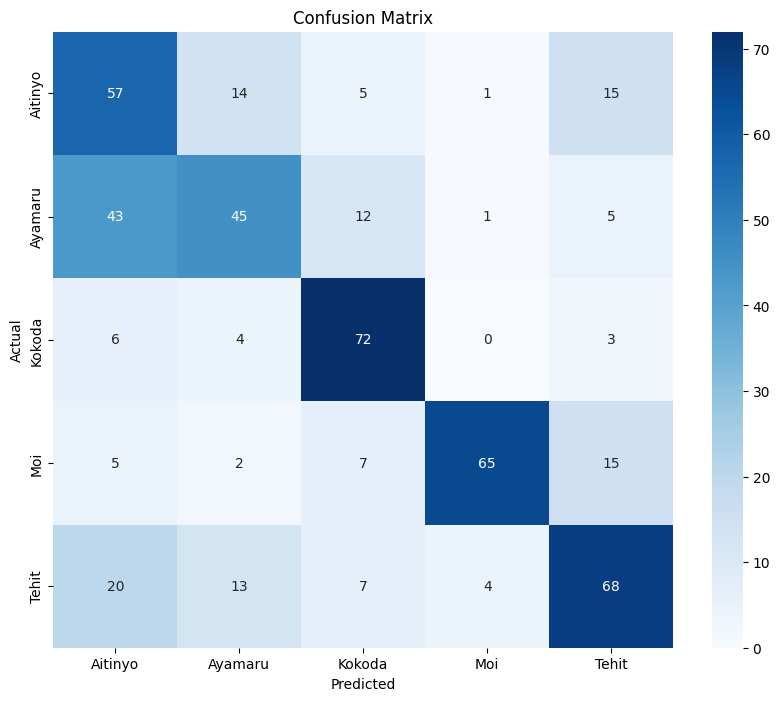

In [ ]:
!pip install pywavelets
import cv2
import numpy as np
import os
import pywt  # Library untuk wavelet transform
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 250

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust the path to your dataset path

# Haar Transform Function
def apply_haar(image):
    """Apply Haar wavelet transform to the image and return the approximation coefficients."""
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Haar wavelet transform (single level)
    coeffs = pywt.dwt2(gray_image, 'haar')
    cA, (cH, cV, cD) = coeffs  # Approximation and details coefficients

    # Normalize approximation coefficients
    cA = cv2.resize(cA, IMAGE_SIZE)  # Resize to match input size
    cA = cv2.normalize(cA, None, 0, 255, norm_type=cv2.NORM_MINMAX)

    # Convert back to 3 channels (RGB format)
    cA_rgb = cv2.cvtColor(cA.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    return cA_rgb

# Preprocessing Function
def preprocess_image(image):
    # Resize image to 224x224 as expected by the model
    image = cv2.resize(image, IMAGE_SIZE)

    # Apply Haar wavelet transform
    haar_image = apply_haar(image)

    return haar_image

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    data.append(image)
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

# Encode labels for training
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_datagen.flow(train_data, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_data, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **GAUSSIAN + HAAR + GABOR**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2162 - loss: 3.5556 - val_accuracy: 0.1739 - val_loss: 2.4822 - learning_rate: 1.0000e-05
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 886ms/step - accuracy: 0.2136 - loss: 3.3767 - val_accuracy: 0.2099 - val_loss: 2.3833 - learning_rate: 1.0000e-05
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 870ms/step - accuracy: 0.2465 - loss: 3.2119 - val_accuracy: 0.2541 - val_loss: 2.3203 - learning_rate: 1.0000e-05
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 860ms/step - accuracy: 0.2442 - loss: 3.1600 - val_accuracy: 0.2991 - val_loss: 2.2711 - learning_rate: 1.0000e-05
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 869ms/step - accuracy: 0.2384 - loss: 3.0995 - val_accuracy: 0.3097 - val_loss: 2.2545 - learning_rate: 1.0000e-05
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 40s 872ms/step - accuracy: 0.2735 - loss: 2.9730 - val_accuracy: 0.3327 - val_loss: 2.2172 - learning_rate: 1.0000e-05
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 857ms/step - accuracy: 

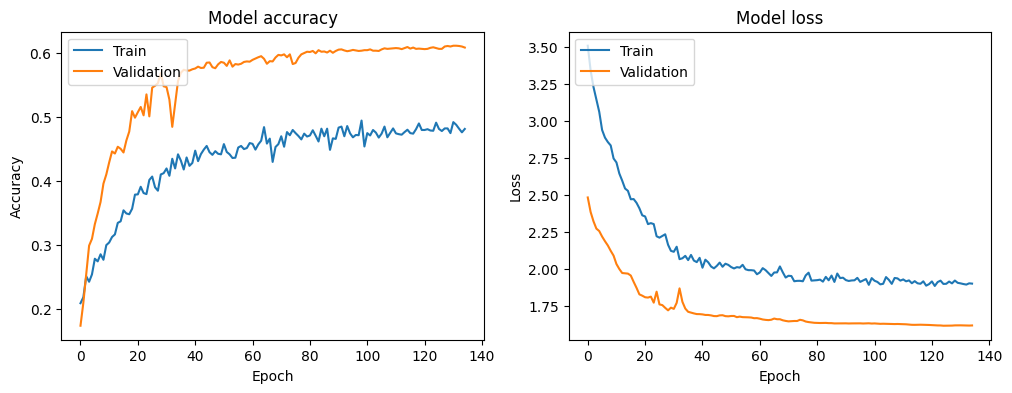

77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step
              precision    recall  f1-score   support

     Aitinyo       0.60      0.41      0.49       500
     Ayamaru       0.61      0.56      0.59       500
      Kokoda       0.51      0.82      0.63       400
         Moi       0.97      0.56      0.72       549
       Tehit       0.53      0.73      0.61       495

    accuracy                           0.61      2444
   macro avg       0.65      0.62      0.61      2444
weighted avg       0.66      0.61      0.61      2444



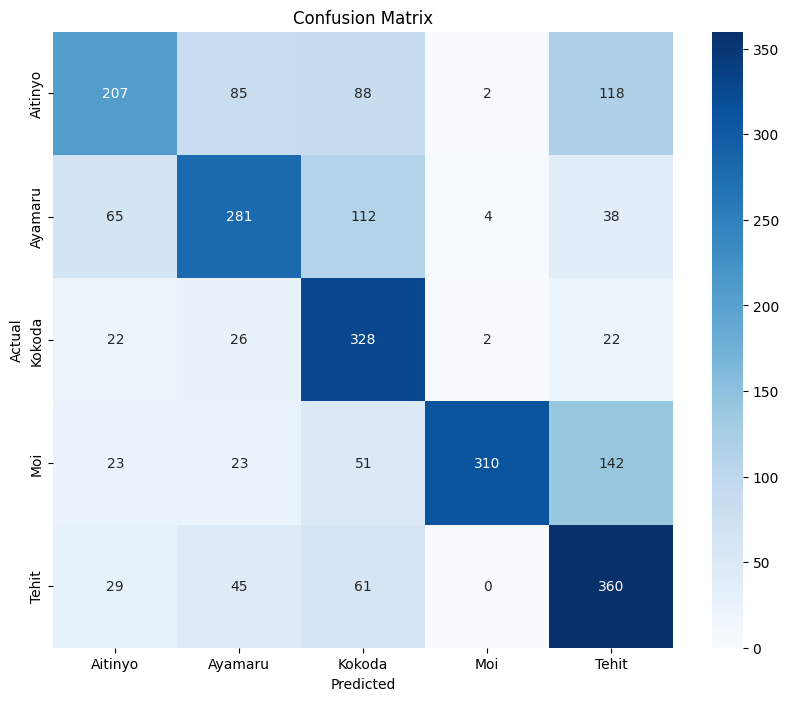

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from skimage.filters import gabor
from scipy.ndimage import gaussian_filter

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 150

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust this path to your dataset location

# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Apply Gaussian filter
    image = gaussian_filter(image, sigma=1)
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Haar wavelet transformation
    image = apply_haar_wavelet(image)
    # Resize back to 224x224 to match the input shape
    image = cv2.resize(image, IMAGE_SIZE)
    # Convert to uint8 for compatibility with cv2
    image = np.clip(image, 0, 255).astype(np.uint8)
    # Convert back to RGB for compatibility with ResNet50
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Function to apply Haar wavelet transformation
def apply_haar_wavelet(image):
    I = image.astype(float)
    m, n = I.shape[:2]
    if m % 2 != 0:
        m -= 1
    if n % 2 != 0:
        n -= 1
    I = I[:m, :n]

    LL = np.zeros((m // 2, n // 2))
    for i in range(0, m, 2):
        for j in range(0, n, 2):
            Ixy = I[i:i + 2, j:j + 2]
            LL[i // 2, j // 2] = np.mean(Ixy)
    return LL

# Function to apply Gabor filter
def apply_gabor_filter(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    # Apply Gabor filter
    filt_real, filt_imag = gabor(image, frequency=0.6)
    return filt_real  # Use the real part of the filter

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    # Apply Gabor filter
                    gabor_image = apply_gabor_filter(image)
                    # Ensure image has 3 channels and resize back to IMAGE_SIZE
                    gabor_image = np.stack([gabor_image] * 3, axis=-1)
                    gabor_image = cv2.resize(gabor_image, IMAGE_SIZE)
                    data.append(gabor_image)  # Append the processed image
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

# Load and preprocess images for CNN
def load_and_preprocess_images(path):
    images = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    image = preprocess_image(image)
                    images.append(image)
                    labels.append(folder)
    return np.array(images), np.array(labels)

train_images, train_labels = load_and_preprocess_images(data_path)
test_images, test_labels = load_and_preprocess_images(data_path)

# Encode labels
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_datagen.flow(train_images, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_images, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels_encoded, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels_encoded, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **HOG**

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.2136 - loss: 8.4177 - val_accuracy: 0.2209 - val_loss: 4.5249
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2256 - loss: 4.1046 - val_accuracy: 0.2658 - val_loss: 3.1172
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2489 - loss: 2.9684 - val_accuracy: 0.2781 - val_loss: 2.4932
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2559 - loss: 2.4837 - val_accuracy: 0.2168 - val_loss: 2.3696
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2218 - loss: 2.3359 - val_accuracy: 0.2740 - val_loss: 2.1720
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2434 - loss: 2.1662 - val_accuracy: 0.2720 - val_loss: 2.0322
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2619 - loss: 2.0540 - val_accuracy: 0.2965 - val_loss: 1.9064
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2635 - loss: 1.9874 - val_accuracy: 0.2965 -

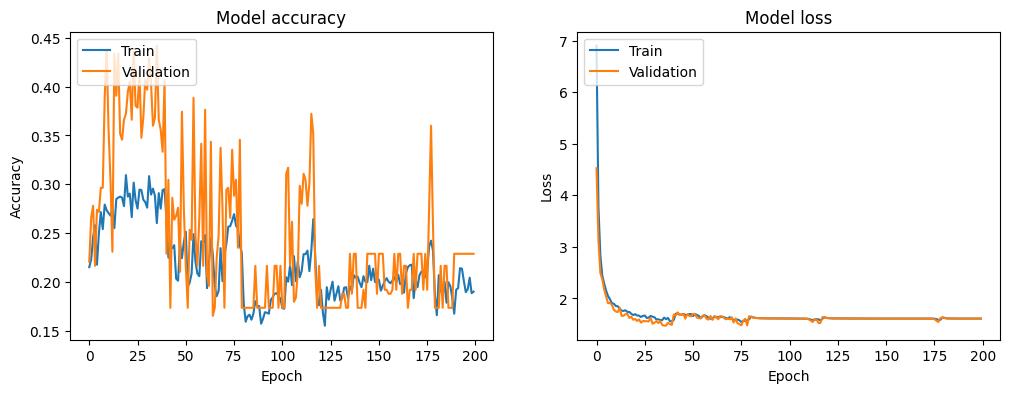

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
              precision    recall  f1-score   support

     Aitinyo       0.00      0.00      0.00        92
     Ayamaru       0.00      0.00      0.00       106
      Kokoda       0.00      0.00      0.00        85
         Moi       0.00      0.00      0.00        94
       Tehit       0.23      1.00      0.37       112

    accuracy                           0.23       489
   macro avg       0.05      0.20      0.07       489
weighted avg       0.05      0.23      0.09       489



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


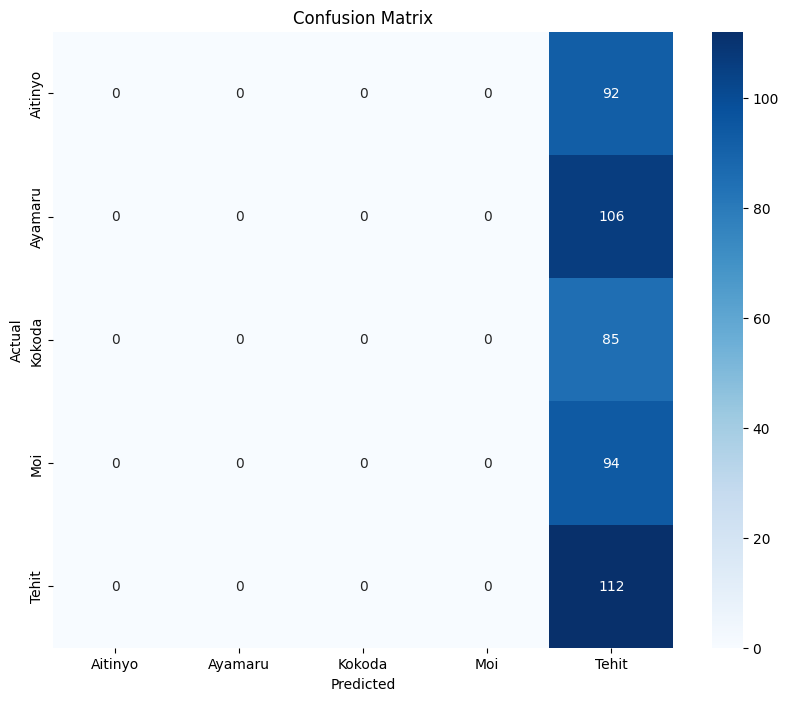

In [ ]:
import cv2
import numpy as np
import os
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 200

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust the path

# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply histogram equalization
    image = cv2.equalizeHist(image)
    return image

# Function to extract HOG features
def extract_hog_features(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    # Extract HOG features
                    hog_features = extract_hog_features(image)
                    data.append(hog_features)  # Append the HOG features
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define a simple model for HOG features
def build_model(input_dim):
    input_tensor = Input(shape=(input_dim,))
    x = Dense(256, activation='relu', kernel_regularizer='l2')(input_tensor)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=predictions)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build model
input_dim = train_data.shape[1]
model = build_model(input_dim)

# Train model
history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    verbose=1
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **GAUSSIAN + HAR + HOG**

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.1888 - loss: 3.5230 - val_accuracy: 0.2050 - val_loss: 3.0200 - learning_rate: 1.0000e-05
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 670ms/step - accuracy: 0.2278 - loss: 3.2519 - val_accuracy: 0.2070 - val_loss: 2.7677 - learning_rate: 1.0000e-05
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 670ms/step - accuracy: 0.2306 - loss: 3.1761 - val_accuracy: 0.2119 - val_loss: 2.6488 - learning_rate: 1.0000e-05
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 670ms/step - accuracy: 0.2463 - loss: 3.1001 - val_accuracy: 0.2291 - val_loss: 2.6302 - learning_rate: 1.0000e-05
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 684ms/step - accuracy: 0.2396 - loss: 3.1149 - val_accuracy: 0.2484 - val_loss: 2.6204 - learning_rate: 1.0000e-05
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 670ms/step - accuracy: 0.2584 - loss: 2.9755 - val_accuracy: 0.2676 - val_loss: 2.5838 - learning_rate: 1.0000e-05
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 690ms/step - accuracy: 

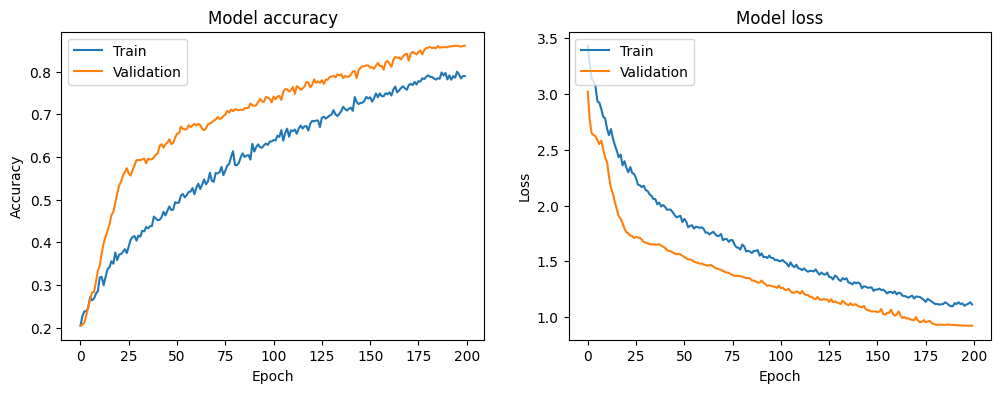

77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step
              precision    recall  f1-score   support

     Aitinyo       0.88      0.92      0.90       500
     Ayamaru       0.82      0.85      0.84       500
      Kokoda       0.98      0.97      0.98       400
         Moi       0.90      0.78      0.84       549
       Tehit       0.75      0.81      0.78       495

    accuracy                           0.86      2444
   macro avg       0.87      0.87      0.87      2444
weighted avg       0.86      0.86      0.86      2444



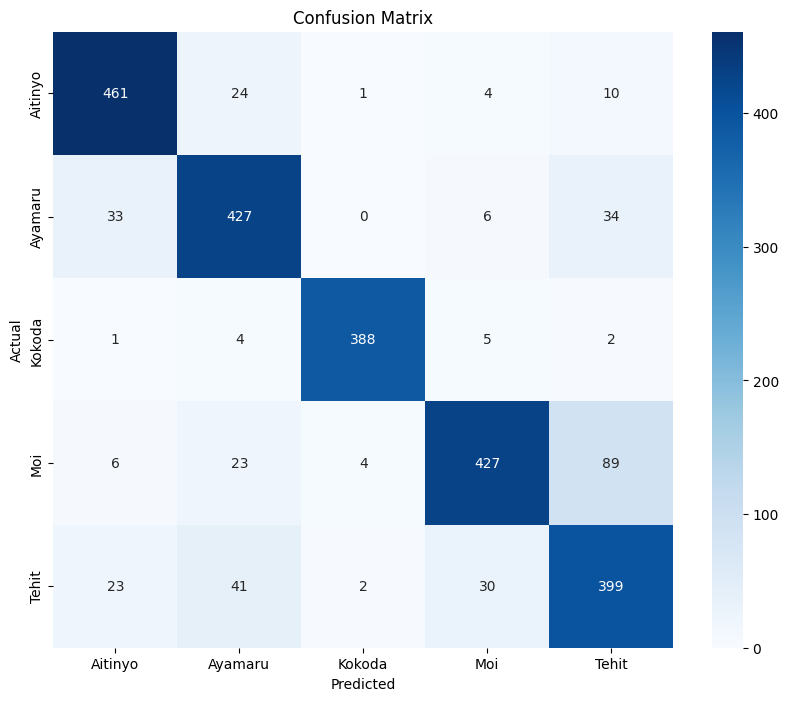

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 200

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust the path to where 'papua-1' and 'papua-2' are located

# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Histogram equalization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    # Apply noise reduction
    image = cv2.fastNlMeansDenoising(image, h=10)
    # Convert back to RGB
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Function to apply Haar wavelet transformation
def apply_haar_wavelet(image):
    I = image.astype(float)
    m, n = I.shape[:2]
    if m % 2 != 0:
        m -= 1
    if n % 2 != 0:
        n -= 1
    I = I[:m, :n]

    LL = np.zeros((m // 2, n // 2))
    for i in range(0, m, 2):
        for j in range(0, n, 2):
            Ixy = I[i:i + 2, j:j + 2]
            LL[i // 2, j // 2] = np.mean(Ixy)
    return LL

# Function to extract HOG features
def extract_hog_features(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    # Apply Haar wavelet
                    haar_image = apply_haar_wavelet(image)
                    # Resize the image to 224x224 for ResNet50
                    haar_image = cv2.resize(haar_image, (224, 224))
                    # Extract HOG features
                    hog_features = extract_hog_features(image)
                    data.append(haar_image)  # Append the processed image
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

# Load and preprocess images for CNN
def load_and_preprocess_images(path):
    images = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    image = preprocess_image(image)
                    images.append(image)
                    labels.append(folder)
    return np.array(images), np.array(labels)

train_images, train_labels = load_and_preprocess_images(data_path)
test_images, test_labels = load_and_preprocess_images(data_path)

# Encode labels
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_datagen.flow(train_images, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_images, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels_encoded, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels_encoded, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **CANNY**

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.2622 - loss: 212.9251 - val_accuracy: 0.3579 - val_loss: 23.4131
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2937 - loss: 84.7023 - val_accuracy: 0.3476 - val_loss: 16.4082
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2698 - loss: 73.0726 - val_accuracy: 0.2331 - val_loss: 13.4130
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2549 - loss: 39.7652 - val_accuracy: 0.2556 - val_loss: 12.9647
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2777 - loss: 39.0121 - val_accuracy: 0.3027 - val_loss: 13.5742
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3018 - loss: 38.8768 - val_accuracy: 0.2924 - val_loss: 13.2451
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3017 - loss: 29.1742 - val_accuracy: 0.2740 - val_loss: 15.5253
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2785 - loss: 25.7475 - val_ac

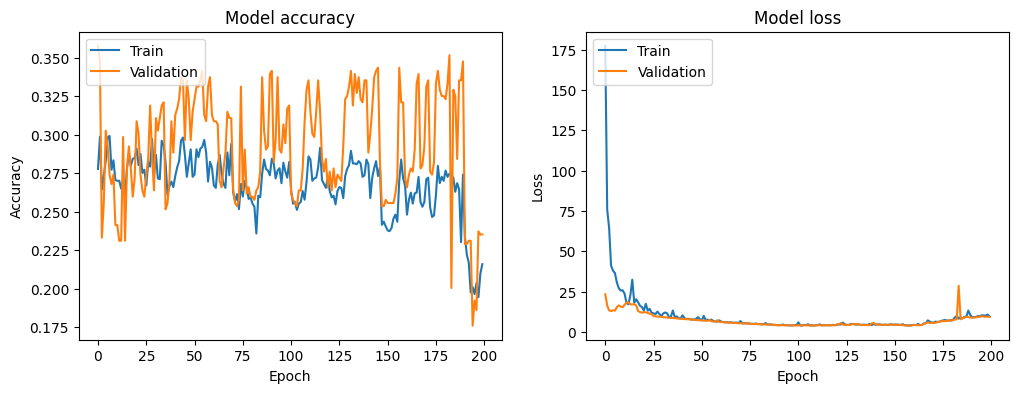

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
              precision    recall  f1-score   support

     Aitinyo       0.00      0.00      0.00        92
     Ayamaru       0.67      0.02      0.04       106
      Kokoda       0.00      0.00      0.00        85
         Moi       1.00      0.01      0.02        94
       Tehit       0.23      1.00      0.38       112

    accuracy                           0.24       489
   macro avg       0.38      0.21      0.09       489
weighted avg       0.39      0.24      0.10       489



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


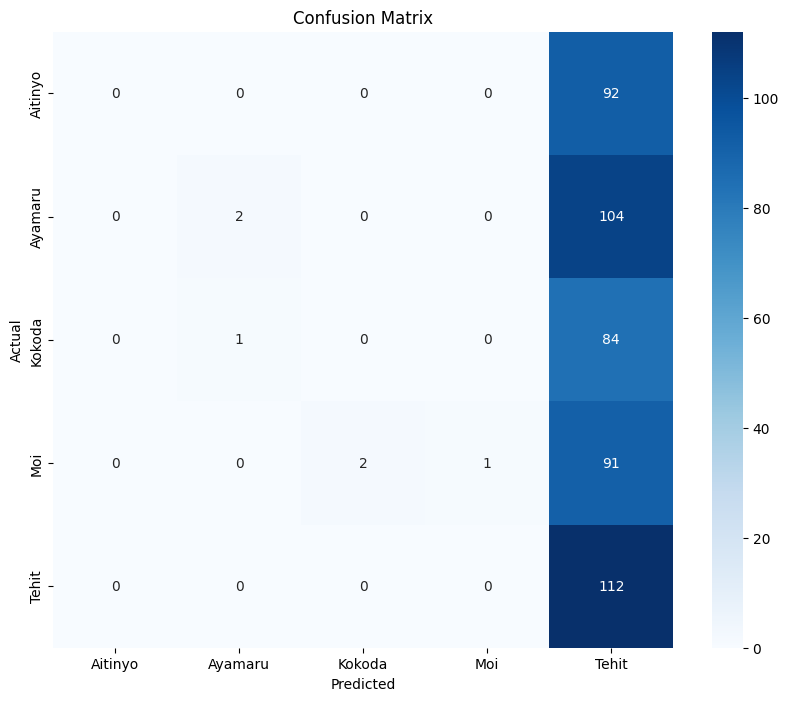

In [ ]:
import cv2
import numpy as np
import os
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 200

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust this path

# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(image, threshold1=100, threshold2=200)
    return edges.flatten()  # Flatten to a 1D array

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image with Canny
                    edges = preprocess_image(image)
                    data.append(edges)  # Append the Canny edges
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define a simple model for Canny features
def build_model(input_dim):
    input_tensor = Input(shape=(input_dim,))
    x = Dense(256, activation='relu', kernel_regularizer='l2')(input_tensor)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=predictions)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build model
input_dim = train_data.shape[1]
model = build_model(input_dim)

# Train model
history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    verbose=1
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **SIFT**

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.2002 - loss: 222.3260 - val_accuracy: 0.2065 - val_loss: 8.1502
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1845 - loss: 19.6474 - val_accuracy: 0.1922 - val_loss: 8.0446
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1768 - loss: 13.3104 - val_accuracy: 0.1902 - val_loss: 7.7935
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1657 - loss: 10.3757 - val_accuracy: 0.1800 - val_loss: 7.5459
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1755 - loss: 9.7527 - val_accuracy: 0.1861 - val_loss: 7.2642
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1601 - loss: 10.2888 - val_accuracy: 0.1738 - val_loss: 6.9963
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1643 - loss: 7.6023 - val_accuracy: 0.1738 - val_loss: 6.7332
Epoch 8/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1551 - loss: 7.6325 - val_accur

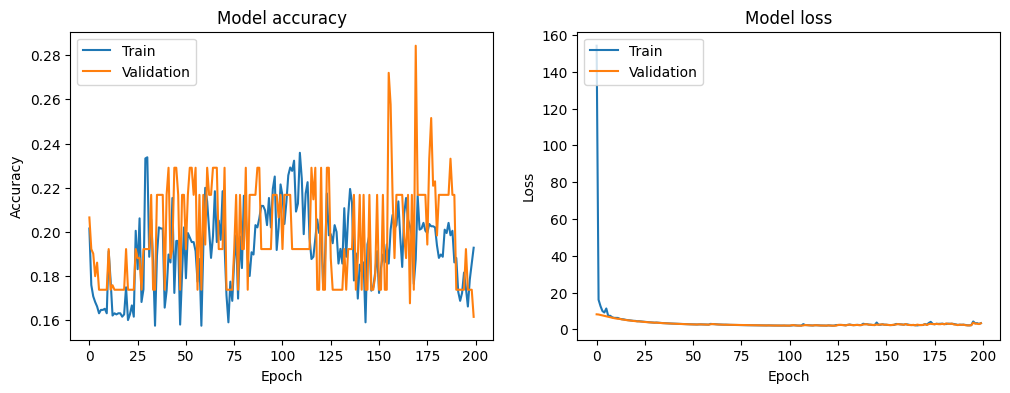

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

     Aitinyo       0.00      0.00      0.00        92
     Ayamaru       0.00      0.00      0.00       106
      Kokoda       0.19      0.78      0.31        85
         Moi       0.09      0.14      0.11        94
       Tehit       0.00      0.00      0.00       112

    accuracy                           0.16       489
   macro avg       0.06      0.18      0.08       489
weighted avg       0.05      0.16      0.07       489



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


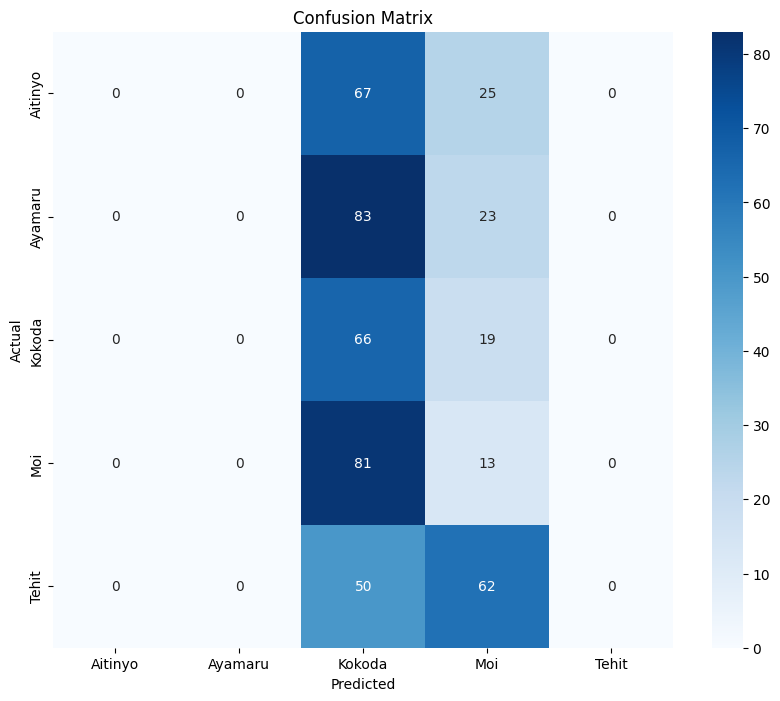

In [ ]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 200

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust the path

# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

# Function to extract SIFT features
def extract_sift_features(image):
    # Initialize SIFT
    sift = cv2.SIFT_create()
    # Detect and compute SIFT features
    keypoints, descriptors = sift.detectAndCompute(image, None)
    # If no descriptors are found, create a zero array
    if descriptors is None:
        descriptors = np.zeros((1, 128))
    # Flatten the descriptors for input to the model
    return descriptors.flatten()

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    # Extract SIFT features
                    sift_features = extract_sift_features(image)
                    data.append(sift_features)  # Append the SIFT features
                    labels.append(folder)

    # Ensure all feature vectors have the same length by padding with zeros
    max_length = max(len(f) for f in data)
    data = [np.pad(f, (0, max_length - len(f)), mode='constant') for f in data]

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define a simple model for SIFT features
def build_model(input_dim):
    input_tensor = Input(shape=(input_dim,))
    x = Dense(256, activation='relu', kernel_regularizer='l2')(input_tensor)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=predictions)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build model
input_dim = train_data.shape[1]
model = build_model(input_dim)

# Train model
history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    verbose=1
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

# Evaluate model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# **LBPH**

# **PCA**

# **GAUSSIAN + EXPLISIT RULES**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/270


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.1975 - loss: 3.3484 - val_accuracy: 0.2770 - val_loss: 2.6951 - learning_rate: 1.0000e-05
Epoch 2/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 666ms/step - accuracy: 0.2264 - loss: 3.1402 - val_accuracy: 0.2668 - val_loss: 2.5995 - learning_rate: 1.0000e-05
Epoch 3/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 688ms/step - accuracy: 0.2439 - loss: 3.1006 - val_accuracy: 0.2672 - val_loss: 2.5189 - learning_rate: 1.0000e-05
Epoch 4/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 31s 667ms/step - accuracy: 0.2730 - loss: 2.9769 - val_accuracy: 0.2696 - val_loss: 2.4439 - learning_rate: 1.0000e-05
Epoch 5/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 669ms/step - accuracy: 0.2502 - loss: 2.9578 - val_accuracy: 0.2705 - val_loss: 2.4297 - learning_rate: 1.0000e-05
Epoch 6/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 669ms/step - accuracy: 0.2813 - loss: 2.7839 - val_accuracy: 0.2676 - val_loss: 2.4313 - learning_rate: 1.0000e-05
Epoch 7/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 685ms/step - accuracy: 

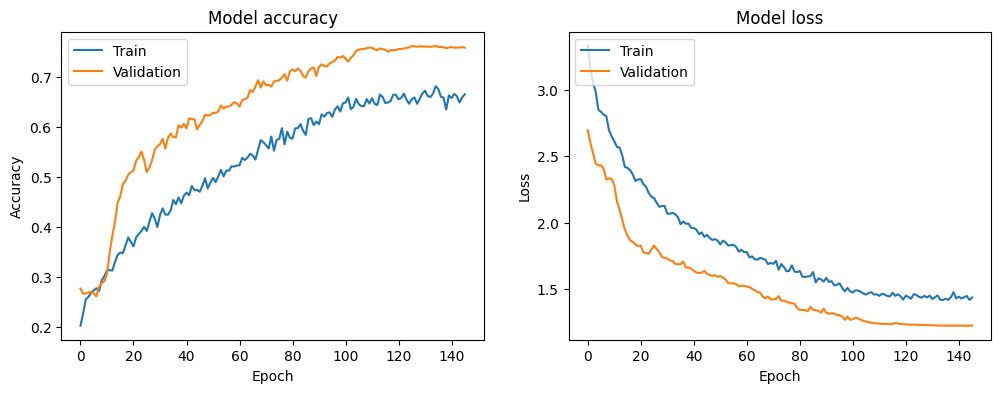

77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step
              precision    recall  f1-score   support

     Aitinyo       0.75      0.74      0.74       500
     Ayamaru       0.67      0.71      0.69       500
      Kokoda       0.86      0.90      0.88       400
         Moi       0.94      0.69      0.79       549
       Tehit       0.66      0.79      0.72       495

    accuracy                           0.76      2444
   macro avg       0.77      0.77      0.76      2444
weighted avg       0.77      0.76      0.76      2444



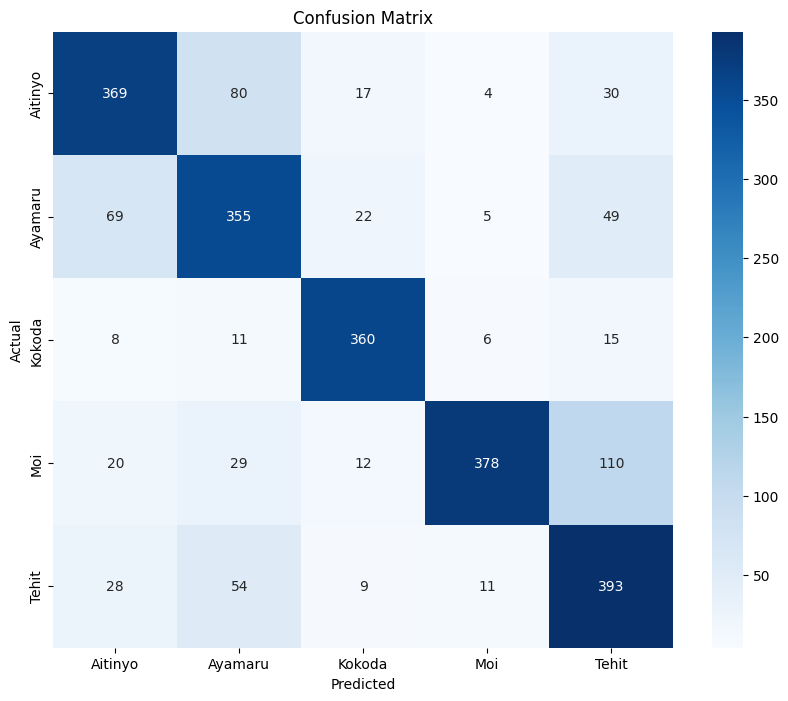

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 270

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust the path to where 'papua-1' and 'papua-2' are located

# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Histogram equalization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    # Apply noise reduction
    image = cv2.fastNlMeansDenoising(image, h=10)
    # Convert back to RGB
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Function to apply Haar wavelet transformation
def apply_haar_wavelet(image):
    I = image.astype(float)
    m, n = I.shape[:2]
    if m % 2 != 0:
        m -= 1
    if n % 2 != 0:
        n -= 1
    I = I[:m, :n]

    LL = np.zeros((m // 2, n // 2))
    for i in range(0, m, 2):
        for j in range(0, n, 2):
            Ixy = I[i:i + 2, j:j + 2]
            LL[i // 2, j // 2] = np.mean(Ixy)
    return LL

# Function to extract HOG features
def extract_hog_features(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    # Apply Haar wavelet
                    haar_image = apply_haar_wavelet(image)
                    # Resize the image to 224x224 for ResNet50
                    haar_image = cv2.resize(haar_image, (224, 224))
                    # Extract HOG features
                    hog_features = extract_hog_features(image)
                    data.append(haar_image)  # Append the processed image
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

# Load and preprocess images for CNN
def load_and_preprocess_images(path):
    images = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    image = preprocess_image(image)
                    images.append(image)
                    labels.append(folder)
    return np.array(images), np.array(labels)

train_images, train_labels = load_and_preprocess_images(data_path)
test_images, test_labels = load_and_preprocess_images(data_path)

# Encode labels
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_datagen.flow(train_images, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_images, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Evaluate model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels_encoded, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels_encoded, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/270


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.2038 - loss: 4.0818 - val_accuracy: 0.2132 - val_loss: 3.1915 - learning_rate: 1.0000e-05
Epoch 2/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 680ms/step - accuracy: 0.2072 - loss: 3.7941 - val_accuracy: 0.2156 - val_loss: 3.0996 - learning_rate: 1.0000e-05
Epoch 3/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 680ms/step - accuracy: 0.2107 - loss: 3.7047 - val_accuracy: 0.2308 - val_loss: 2.9813 - learning_rate: 1.0000e-05
Epoch 4/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 695ms/step - accuracy: 0.2254 - loss: 3.4459 - val_accuracy: 0.2394 - val_loss: 2.8609 - learning_rate: 1.0000e-05
Epoch 5/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 676ms/step - accuracy: 0.2438 - loss: 3.3195 - val_accuracy: 0.2426 - val_loss: 2.7839 - learning_rate: 1.0000e-05
Epoch 6/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 693ms/step - accuracy: 0.2308 - loss: 3.2178 - val_accuracy: 0.2451 - val_loss: 2.6585 - learning_rate: 1.0000e-05
Epoch 7/270
39/39 ━━━━━━━━━━━━━━━━━━━━ 32s 681ms/step - accuracy: 

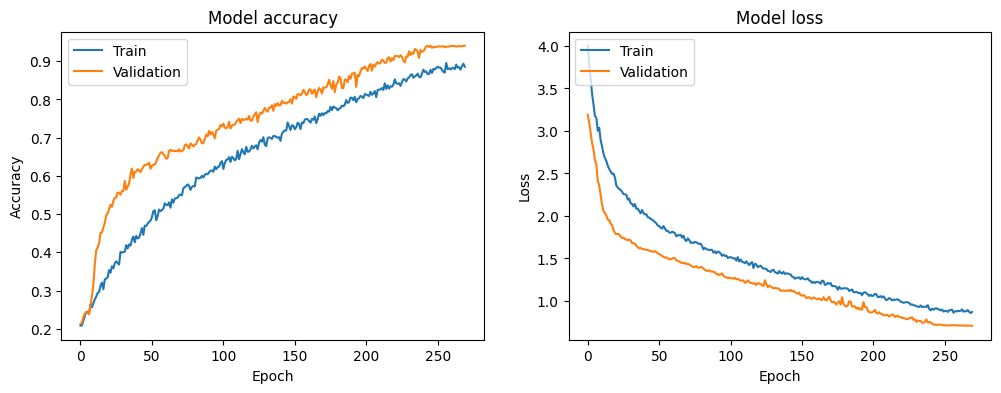

77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step
              precision    recall  f1-score   support

     Aitinyo       0.97      0.98      0.98       500
     Ayamaru       0.98      0.98      0.98       500
      Kokoda       0.99      0.99      0.99       400
         Moi       0.96      0.83      0.89       549
       Tehit       0.82      0.95      0.88       495

    accuracy                           0.94      2444
   macro avg       0.95      0.95      0.94      2444
weighted avg       0.94      0.94      0.94      2444



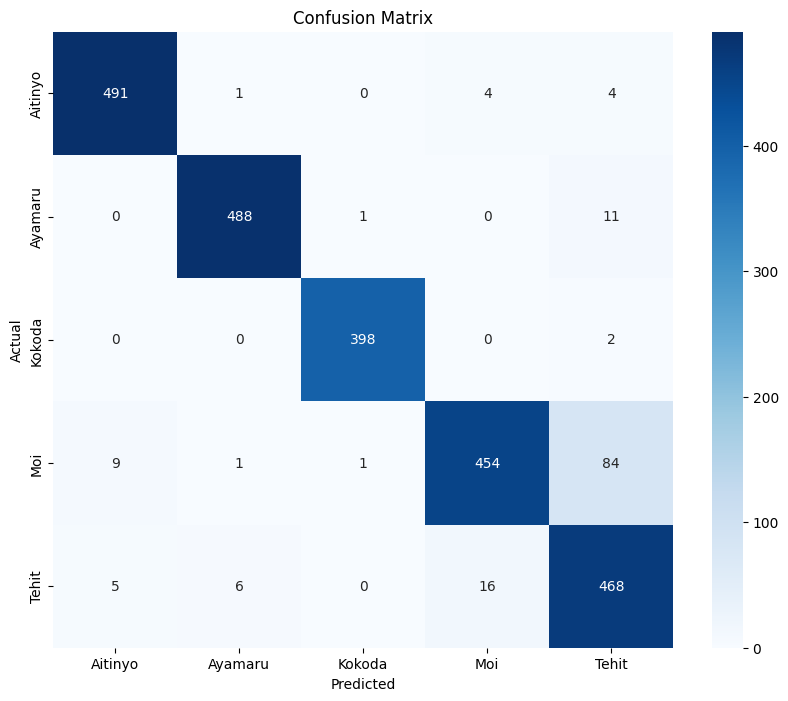

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight


# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 270

# Paths
data_path = "/content/drive/MyDrive/OBJECTIVE"  # Adjust the path to where 'papua-1' and 'papua-2' are located

# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Histogram equalization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    # Apply noise reduction
    image = cv2.fastNlMeansDenoising(image, h=10)
    # Convert back to RGB
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# Function to apply Haar wavelet transformation
def apply_haar_wavelet(image):
    I = image.astype(float)
    m, n = I.shape[:2]
    if m % 2 != 0:
        m -= 1
    if n % 2 != 0:
        n -= 1
    I = I[:m, :n]

    LL = np.zeros((m // 2, n // 2))
    for i in range(0, m, 2):
        for j in range(0, n, 2):
            Ixy = I[i:i + 2, j:j + 2]
            LL[i // 2, j // 2] = np.mean(Ixy)
    return LL

# Function to extract HOG features
def extract_hog_features(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

# Load and preprocess data
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)
                    # Apply Haar wavelet
                    haar_image = apply_haar_wavelet(image)
                    # Resize the image to 224x224 for ResNet50
                    haar_image = cv2.resize(haar_image, (224, 224))
                    # Extract HOG features
                    hog_features = extract_hog_features(image)
                    data.append(haar_image)  # Append the processed image
                    labels.append(folder)

    return np.array(data), np.array(labels)

# Load dataset
data, labels = load_data(data_path)

# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

# Split into training and testing
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

# Load and preprocess images for CNN
def load_and_preprocess_images(path):
    images = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    image = preprocess_image(image)
                    images.append(image)
                    labels.append(folder)
    return np.array(images), np.array(labels)

train_images, train_labels = load_and_preprocess_images(data_path)
test_images, test_labels = load_and_preprocess_images(data_path)

# Encode labels
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    train_datagen.flow(train_images, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_images, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Evaluate model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels_encoded, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels_encoded, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()